<a href="https://colab.research.google.com/github/MHadavand/Lessons/blob/master/ML/ANN/GPU_CNN/CNN-MNIST-Dataset_CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1 align="center"><font size="5">CONVOLUTIONAL NEURAL NETWORK</font></h1>

<h2>Helper Functions</h2>

In [1]:
from matplotlib import pyplot as plt
from matplotlib import animation
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from matplotlib import rc
import seaborn as sn

rc('animation', html='jshtml')

def flatten_images(image):
    '''
    Flatten an image
    '''
    original_shape = image.shape # (number_images by y_pixels(rows) by x_pixels(columns))
    return image.reshape(original_shape[0], original_shape[1]*original_shape[1])

def transform_label(x):
    ''' Using the one hot concept to model the 9 discrete possible integer values for classification to get
        probability of each class. Using argmax function allows us to get the correct class i.e. 0, 1, 2, ... 9
    '''
    one_hot = []
    for item in x:
        one_hot.append([float(int(i==item)) for i in range(0,10)])
    return np.array(one_hot)

def image_plot(image, digit, cmap='bone_r', figsize=(5,5)):
    '''
    A function to plot images
    '''
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.text(0.1,0.85,'Label : {}'.format(digit), fontsize=15, color ='b', transform=ax.transAxes)
    _ = ax.imshow(image, cmap='bone_r')
    
    
def mnist_result_anim(images, digits_true, digits_predicted, shape=[28,28], cmap='bone_r', interval=500, repeat=True, n_iterations = None, video_file=None):

    try:
        _ = digits_true.shape[1]
    except:
        digits_true = transform_label(digits_true)

    fig, ax = plt.subplots(1,1,figsize=(6,6))
    image = ax.imshow(np.zeros([28,28]), cmap=cmap)
    true_digit = ax.text(0.1, 0.9, s='True Value:', fontsize=12, transform = ax.transAxes, color='b')
    predicted_digit = ax.text(0.1, 0.85, s='PredictedValue:', fontsize=12, transform = ax.transAxes, color='g')

    def update(i):
        image=ax.imshow(images[i].reshape(shape[0],shape[1]),cmap=cmap)
        true_digit.set_text('True Value: {}'.format(np.argmax(digits_true[i])))
        predicted_digit.set_text('PredictedValue: {}'.format(np.argmax(digits_predicted[i])))
        color = '{}'.format('g' if np.argmax(digits_true[i]) == np.argmax(digits_predicted[i]) else 'r')
        predicted_digit.set_color(color)
        return image, true_digit, predicted_digit,
    if n_iterations is None:
        n_iterations = len(images)
    anim = animation.FuncAnimation(fig, update, frames=n_iterations, interval=interval, blit=True, repeat=repeat)
    if video_file is not None:
        anim.save('{video_file}.gif'.format(video_file=video_file),writer='pillow', fps=30)
    return anim

In [2]:
class Config():
    '''
    A class for configuration of CNN
    '''
    def __init__(self, batch_size, n_epochs, train_portion, min_delta, stop_patience, lr_patience=None, rnn_nodes = None, repeated_predictions=False, monitor ='loss'):    
        self.repeated_predictions = repeated_predictions
        self.batch_size = batch_size
        self.rnn_nodes = rnn_nodes
        self.n_epochs = n_epochs
        self.train_portion = train_portion
        
        # Early stop call back for keras
        self.early_stop_clbk = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                                min_delta=min_delta, 
                                                                patience=stop_patience,
                                                                verbose=0, 
                                                                mode='auto',
                                                                restore_best_weights=True)
        if lr_patience is not None:
            # Adaptive learning rate call back for keras
            self.lr_plan = ReduceLROnPlateau(monitor='val_loss',
                                             factor=0.1,patience=lr_patience,
                                             verbose=0,
                                             mode='auto',
                                             min_delta=min_delta)

<h2>Introduction</h2>

<p>In this section, we will use the famous <a href="http://yann.lecun.com/exdb/mnist/">MNIST</a> to build a Convolutional Neural Networks capable to perform handwritten digits classification. CNN will say, with some associated error, what type of digit is the presented input.</p>

<h2 id="deep_learning_MNIST">Deep Learning with CNN applied on MNIST</h2>

<p>We are going to create a simple CNN to perform classification tasks on the MNIST digits dataset. If you are not familiar with the MNIST dataset, you could read more about it: <a href="http://yann.lecun.com/exdb/mnist/">click here</a></p>

<h3>What is MNIST?</h3>

<p>According to Lecun's website, the MNIST is a: "database of handwritten digits that has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from the National Institute of Standards and Technology (NIST). The digits have been size-normalized and centered in a fixed-size image".</p>

<h3>Import the MNIST dataset using TensorFlow built-in feature</h3>

<p>It's very important to notice that MNIST is a high optimized data-set and it does not contain images. You will need to build your own code if you want to see the real digits. Another important side note is the effort that the authors invested on this data-set with normalization and centering operations.</p>  

In [3]:
import time
import tensorflow as tf
print(tf.__version__)

2.1.0


<h3>Evaluate avilibility of CPU and GPU device</h3>

In [7]:
tf.config.experimental.list_physical_devices('CPU'), tf.config.experimental.list_physical_devices('GPU')

([PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')], [])

In [8]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

# Normalize pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

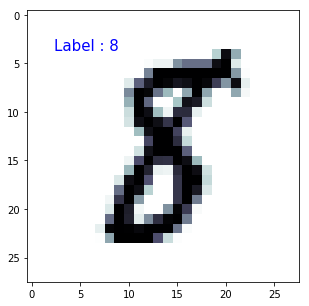

In [9]:
image_plot(x_train[125], y_train[125])

In [10]:
# One hot transformation
y_train, y_test = transform_label(y_train), transform_label(y_test)

<p>The <code>one-hot = True</code> argument only means that, in contrast to Binary representation, the labels will be presented in a way that only one bit will be on for a specific digit.</p>

<h3>Understanding the imported data</h3>

The imported data can be divided as follow:

<ul>
    <li>Training (mnist.train):  Use the given dataset with inputs and related outputs for training of NN. In our case, if you give an image that you know that represents a "nine", this set will tell the neural network that we expect a "nine" as the output.
        <ul>
            <li>55,000 data points</li>
            <li>mnist.train.images for inputs</li>
            <li>mnist.train.labels for outputs</li>
        </ul>
    </li>
    <li>Validation (mnist.validation): The same as training, but now the data is used to generate model properties (classification error, for example) and from this, tune parameters like the optimal number of hidden units or determine a stopping point for the back-propagation algorithm.
        <ul>
            <li>5,000 data points</li>
            <li>mnist.validation.images for inputs</li>
            <li>mnist.validation.labels for outputs</li>
        </ul>        
    </li>
    <li>Test (mnist.test): the model does not have access to this informations prior to the test phase. It is used to evaluate the performance and accuracy of the model against "real life situations". No further optimization beyond this point.
        <ul>
            <li>10,000 data points</li>
            <li>mnist.test.images for inputs</li>
            <li>mnist.test.labels for outputs</li>
        </ul>         
    </li>
</ul>

<h3>Input and Output</h3>

<b>Input 'X':</b> represents the "space" allocated input or the images.
<ul>
    <li>Each input has 784 pixels distributed by a 28 width x 28 height matrix.</li>
    <li>The 'shape' argument defines the tensor size by its dimensions.</li>
    <li>1st dimension = None. Indicates that the batch size, can be of any size.</li>
    <li>2nd dimension = 784. Indicates the number of pixels on a single flattened MNIST image.</li> 
</ul>

<b>Output 'Y':</b> represents the final output or the labels.  
<ul>
    <li>10 possible classes (0, 1, 2, 3, 4, 5, 6, 7, 8, 9).</li>
    <li>The 'shape' argument defines the tensor size by its dimensions.</li>
    <li>1st dimension = None. Indicates that the batch size, can be of any size.</li>
    <li>2nd dimension = 10. Indicates the number of targets/outcomes.</li> 
</ul>

<p><b>dtype for both placeholders:</b> if you not sure, use tf.float32. The limitation here is that the later presented softmax function only accepts float32 or float64 dtypes. For more dtypes, check TensorFlow's documentation <a href="https://www.tensorflow.org/api_docs/python/tf/dtypes/DType">here</a>.</p>

<h3>Convolutional neural networks (CNNs)</h3>

<p>Convolutional neural networks (CNNs) is a type of feed-forward neural network, consist of multiple layers of  neurons that have trainable weights and biases. Each neuron in a layer that receives some input, process it, and optionally follows it with a non-linearity. The network has multiple layers such as convolution, max pool, drop out and fully connected layers. In each layer, small neurons process portions of the input image. The outputs of these collections are then tiled so that their input regions overlap, to obtain a higher-resolution representation of the original image; and it is repeated for every such layer. The important point here is: CNNs are able to break the complex patterns down into a series of simpler patterns, through multiple layers.</p>

The covolutional layer is in fact a moving averaging window with a a trainable kernel/weights that can be used to capture certain features of an image or video or an array. The convolution of f and g is written f∗g. It is defined as the integral/summation of the product of the two functions after one is reversed and shifted.

$$
f * g (t) = \int f(\tau)g(t-\tau) \, d\tau
$$

An example for architecture of a typical deep CNN network is:
<ul> 
    <li>Input [?, 28, 28, 1]: 2D image with one input channel (gray scale vs three channel for RGB). This is known as NHWC format (number of images, height, width and channels)</li>
    <li> First convolutional layer: Apply 32 filter of [5x5]. The kernel averaging window size is 5x5 and we selected to have 32 output channels. The number of trainable parameters (i.e. wights and biases) is (5\*5\*1 + 1)\*32</li>
    <li>Output of the first convolutional layer: [?, 28, 28, 32] depending on definition of strides and padding, the output size may or may not match the input size.</li>
    <li>Applying the activation function (ReLU 1): The output shape is not changed i.e. [?, 28, 28, 32]</li>
    <li>Pooling layer (i.e. Max pooling 1): Pool size determines the size of pooling window and strides define the output size. With the pool size of 2 and strides of 2, the output shape will be [?, 14, 14, 32]</li>
    <li>Convolutional layer 2: 64 kernels with the size of 5x5 results in output shape of [?, 14, 14, 64]. Number of parameters is (5\*5\*32 + 1)\*64 i.e. kernel size \* number of input channels \* number of output channels +number of biases (1 per output channel) </li>
    <li>Non linear activation (i.e. ReLU 2): The output shape is not changed i.e. [?, 14, 14, 64]</li>
    <li> Pooling (i.e. Max pooling 2): With strides of size 2 along width and height  [?, 7, 7, 64]</li>
    <li>Flatten layer: Convert the 2D image and the output channels from the previous layer into a flat array. The output size is [? 3136(7\*7\*64)]</li>
    <li>fully connected layer (i.e layer 3): Fully connected layer with 1024 neurons results in an output with shape of [? 1024]. The number of parameters is 3136*1024 + 1024</li>
    <li>Activation layer (i.e. ReLU 3):  Output shape remains [? 1024]</li>
    <li>Drop out layer to implement generalization: Output shape remains [? 1024]</li>
    <li>fully connected layer (i.e. layer 4): Output shape of [? 10] that maps to the 10 classes of digits from 0 to 9</li>
</ul>

<img src="https://ibm.box.com/shared/static/vn26neef1nnv2oxn5cb3uueowcawhkgb.png" style="width:800px; height:400px;" alt="HTML5 Icon" >

<h4>Convolve with weight tensor and add biases.</h4>

Inputs:
<ul>
    <li>Tensor of shape [batch, in_height, in_width, in_channels]. input (i.e. x) of shape [batch_size,28 ,28, 1].</li>
    <li>A filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]. W is of size [5, 5, 1, 32].</li>
    <li>Stride which is  [1, 1, 1, 1]. The convolutional layer, slides the "kernel window" across the input tensor. As the input tensor has 4 dimensions:  [batch, height, width, channels], then the convolution operates on a 2D window on the height and width dimensions. <b>strides</b> determines how much the window shifts by in each of the dimensions. As the first and last dimensions are related to batch and channels, we set the stride to 1. But for second and third dimension, we could set other values, e.g. [1, 2, 2, 1].</li>
</ul>
    
Process:
<ul>
    <li>Change the filter to a 2-D matrix with shape [5\*5\*1, 32].</li>
    <li>Extracts image patches from the input tensor to form a <i>virtual</i> tensor of shape <code>[batch, 28, 28, 5\*5\*1]</code>.</li>
    <li>For each batch, right-multiplies the filter matrix and the image vector.</li>
</ul>

Output:
<ul>
    <li>A <code>Tensor</code> (a 2-D convolution) of size (?, 28, 28, 32).</li>
    <li>Notice: the output of the first convolution layer is 32 [28x28] images. Here 32 is considered as volume/depth of the output image.</li>
</ul>

<img src="https://ibm.box.com/shared/static/iizf4ui4b2hh9wn86pplqxu27ykpqci9.png" style="width:800px;height:400px;" alt="HTML5 Icon">

<h4>Stride! How does it work?</h4>

Stride is a parameter of the neural network's filter that modifies the amount of movement over the image or video an can be used for compression. For example, if a neural network's stride is set to 1, the filter will move one pixel, or unit,  at a time. The size of the filter affects the encoded output volume, so stride is often set to a whole integer, rather than a fraction or decimal.

<img src="https://images.deepai.org/django-summernote/2019-06-03/56e53bc1-bac3-48f4-a08c-dce77a57464b.png">


Imagine a convolutional neural network is taking an image and analyzing the content. If the filter size is 3x3 pixels, the contained nine pixels will be converted down to 1 pixel in the output layer. Naturally, as the stride, or movement, is increased, the resulting output will be smaller. Stride is a parameter that works in conjunction with padding, the feature that adds blank, or empty pixels to the frame of the image to allow for a minimized reduction of size in the output layer. Roughly, it is a way of increasing the size of an image, to counteract the fact that stride reduces the size. Padding and stride are the foundational parameters of any convolutional neural network.

<img src="https://images.deepai.org/django-summernote/2019-06-03/5f9e90ca-1405-4fcb-9d43-071d7f710950.png">


As was explained above, <b>stride</b> determines how much the window shifts by in each of the dimensions. For image classification, stride is often a tuple with 4 dimensions. As the first and last dimensions are related to batch and channels, we set the stride to 1. But for second and third dimension, we could set other values, e.g. [1, 2, 2, 1] This means that the convolutional filter/kernel moves 2 cell along width and height of the image.

<h4>Apply the ReLU activation Function</h4>

<p>In this step, we just go through all outputs convolution layer, <b>convolve1</b>, and wherever a negative number occurs,we swap it out for a 0. It is called ReLU activation Function.</p> 
<p>Let f(x) is a ReLU activation function $f(x) = max(0,x)$.</p>

<h4>Apply the max pooling</h4>

<p><b>max pooling</b> is a form of non-linear down-sampling. It partitions the input image into a set of rectangles and, and then find the maximum value for that region.</p>

<p>Lets use <b>tf.nn.max_pool</b> function to perform max pooling. 
<b>Kernel size:</b> 2x2 (if the window is a 2x2 matrix, it would result in one output pixel).</p>
    
<p><b>Strides:</b> dictates the sliding behaviour of the kernel. In this case it will move 2 pixels everytime, thus not overlapping. The input is a matrix of size 28x28x32, and the output would be a matrix of size 14x14x32.</p>

<img src="https://ibm.box.com/shared/static/kmaja90mn3aud9mro9cn8pbbg1h5pejy.png" alt="HTML5 Icon" style="width:800px; height:400px;"> 

<h4>Fully Connected Layer</h4>

<p>The fully connected layer is needed to use the Softmax and create the probabilities in the end. Fully connected layers take the high-level filtered images from previous layer, that is all 64 matrices, and convert them to a flat array.</p>

<p>So, each matrix [7x7] will be converted to a matrix of [49x1], and then all of the 64 matrix will be connected, which make an array of size [3136x1]. This will connect into another layer of size [1024x1]. So, the weight between these 2 layers will be [3136x1024].</p>


<img src="https://ibm.box.com/shared/static/pr9mnirmlrzm2bitf1d4jj389hyvv7ey.png" alt="HTML5 Icon" style="width:800px; height:400px;">

<h4>SoftMax Activation Function</h4>

The softmax function, also known as softargmax or normalized exponential function is a generalization of the logistic function to multiple dimensions. It is used in multinomial logistic regression and is often used as the last activation function of a neural network to normalize the output of a network to a probability distribution over predicted output classes.

Consider an input vector of **Z** of K real numbers. Applying the soft max function results in a each component to be in the interval (0, 1) and sum to 1.  

$\sigma(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K}e^{z_j}}$

For the MNIST data set, the output layer of the network is an array of length 10 to indicate the probability of each digit and soft max activation is used to normalize the output and transform it to a probability distribution.

<h4>Categorical Cross Entropy Loss</h4>

The categorical cross entropy loss function quantifies the miss classification between two arrays that represent the probability distribution of different classes.

Loss = $ -\sum_{i=1}^{K} y_i.log\hat{y}_j$

<img src="https://miro.medium.com/max/700/0*YRAt7P06fL7TObX-.png" style="width:600px; height:200px;">

<h4>High level over view of CNN</h4>

Image below shows a summary of CNN design

<img src="https://miro.medium.com/max/700/0*GDlFcyG1CV2OGEbX.png">

<h3>Implementing the network architecture</h3>

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import LSTM, SimpleRNN, Dropout, GRU, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, Nadam

<h4>Parameters and Settings</h4>

In [12]:
width = 28 # width of the image in pixels 
height = 28 # height of the image in pixels
flat = width * height # number of pixels in one image 
class_output = 10 # number of possible classifications for the problem

In [13]:
# Reshape the image to ? x 28 x 28 x 1
if x_train.shape[-1] !=1:
    x_train = x_train[:, :, :, np.newaxis]
    x_test = x_test[:, :, :, np.newaxis]

<h4>Using keras to design the network</h4>

In [14]:
# Creat the model
model = Sequential(name='CnnSequential')

# Adding the first CNN layer
#-------------------------------------------
model.add(Conv2D(filters= 32
                 ,kernel_size = (5, 5)
                 ,strides = (1,1)
                 ,input_shape=(28, 28, 1) # Width, Height and number of input channels. The number of batches is implicit
                 ,activation='relu' # Rectifie linear (the nonlinear activation function)
                 ,padding='same' # Padding for the edges of the image as the kernel moves
                 ,name='ConvLayer1')) 
# Adding the max pool process to compress image
model.add(MaxPool2D(pool_size = [2,2], strides=(2,2), padding='same', name='MaxPool1'))

# Adding the second CNN layer
#-------------------------------------------
model.add(Conv2D(filters= 64
                 ,kernel_size = (5, 5)
                 ,strides = (1,1)
                 ,activation='relu' # Rectifie linear (the nonlinear activation function)
                 ,padding='same' # Padding for the edges of the image as the kernel moves
                 ,name='ConvLayer2')) 

# Adding the max pool process to compress image
model.add(MaxPool2D(pool_size = [2,2], strides=(2,2), padding='same', name='MaxPool2'))

# Flatten the process images after CNNs with all the channels
#-----------------------------------------------------------------
model.add(Flatten(name='Flatten'))

# Adding a dense layer before the final output
#-----------------------------------------------------------------
model.add(Dense(1024, activation='relu', name='Dense'))

# Adding a drop out process
#-----------------------------------------------------------------
model.add(Dropout(rate=0.1, name='DropOut'))

# The final layer to map to 10 classes
#-----------------------------------------------------------------
model.add(Dense(10, activation='softmax', name='Output'))


model.compile(loss='categorical_crossentropy', 
              optimizer=Nadam(learning_rate=0.001), 
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

model.summary()

Model: "CnnSequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ConvLayer1 (Conv2D)          (None, 28, 28, 32)        832       
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 14, 14, 32)        0         
_________________________________________________________________
ConvLayer2 (Conv2D)          (None, 14, 14, 64)        51264     
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 7, 7, 64)          0         
_________________________________________________________________
Flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
Dense (Dense)                (None, 1024)              3212288   
_________________________________________________________________
DropOut (Dropout)            (None, 1024)            

<h4>Review the number of parameters for each layer</h4>

- First CNN: size of the kernel \* number of input channels \* number of out put channels + Number of biases (1 per output channel) e.g. 5\*5\*1\*32 + 32 = 832

- Second CNN: size of the kernel \* number of input channels \* number of out put channels + Number of biases (1 per output channel) e.g. 5\*5\*32\*64 + 64 = 51264

- Flatten layer: flatten image size \* number of channels e.g. 7\*7\*64 = 3136

- Dense layer: Number of neurons from previous layer \* number of neurons on current layer + biases (one per output neuron) e.g. 3136\*1024 + 1024 = 3212288

- Last layer: Number of neurons from previous layer \* number of neurons on current layer + biases (one per output neuron) e.g. 1024\*10 + 10 = 10250 

In [15]:
# Central configuration
config = Config(batch_size=500, n_epochs = 30, train_portion = 0.7, min_delta=0.001, stop_patience=200)

In [ ]:
history = model.fit(x_train, y_train, epochs=config.n_epochs, 
                    batch_size=config.batch_size,
                    validation_data=(x_test, y_test), 
                    callbacks=[config.early_stop_clbk])

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.2909 - categorical_accuracy: 0.9109 - val_loss: 0.0588 - val_categorical_accuracy: 0.9807
Epoch 2/30
60000/60000 [==============================] - 83s 1ms/sample - loss: 0.0584 - categorical_accuracy: 0.9819 - val_loss: 0.0372 - val_categorical_accuracy: 0.9882
Epoch 3/30
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.0376 - categorical_accuracy: 0.9883 - val_loss: 0.0301 - val_categorical_accuracy: 0.9901
Epoch 4/30
60000/60000 [==============================] - 91s 2ms/sample - loss: 0.0277 - categorical_accuracy: 0.9912 - val_loss: 0.0251 - val_categorical_accuracy: 0.9906
Epoch 5/30
60000/60000 [==============================] - 90s 1ms/sample - loss: 0.0202 - categorical_accuracy: 0.9939 - val_loss: 0.0295 - val_categorical_accuracy: 0.9901
Epoch 6/30
60000/60000 [==============================] - 74s 1ms/sample - loss: 0.01

<h4>Visualizations</h4>

In [80]:
prediction = model.predict(x_test)

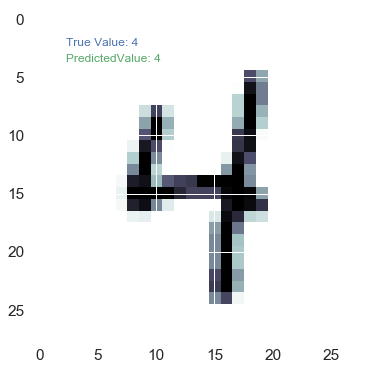

In [81]:
# animation of image vs prediction for test data set
mnist_result_anim(x_test[0:20],y_test[0:20], prediction[0:20], interval=50)

Text(0.5, 1.0, 'Confusion Matrix for Test Data')

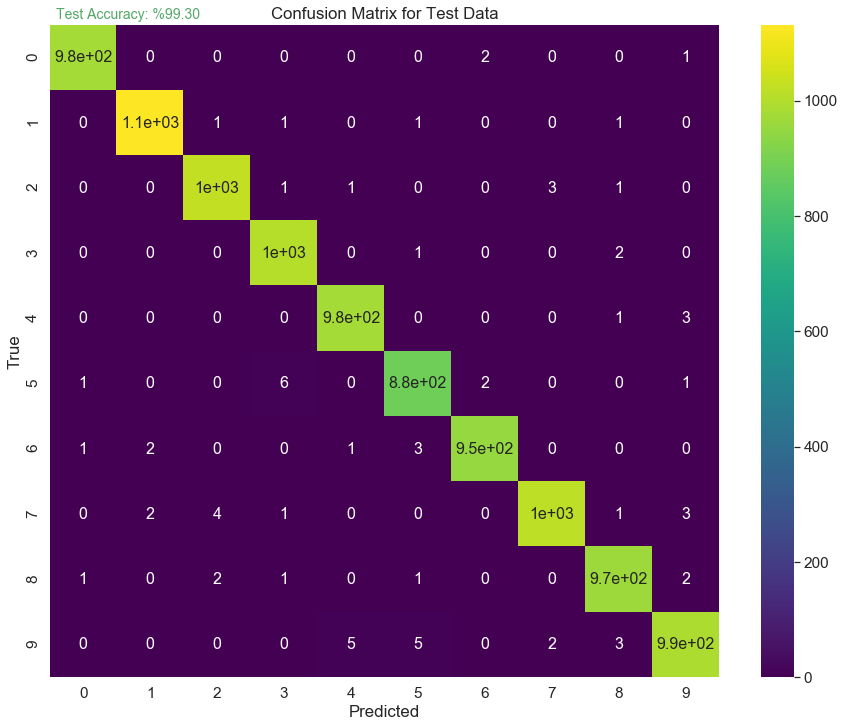

In [82]:
cm = confusion_matrix(list(map(np.argmax, y_test)), list(map(np.argmax, prediction)))
df_cm = pd.DataFrame(cm, range(10), range(10))

# trace of the confusion matrix is the count of correct calssifications
accuracy = (np.trace(cm) / np.sum(cm)) * 100


sn.set(font_scale=1.4)
fig, ax = plt.subplots(figsize=(15,12))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, ax=ax, cmap='viridis')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.text(0.01, 1.01, s='Test Accuracy: %{:.2f}'.format(accuracy), fontsize=14, transform = ax.transAxes, color='g')
ax.set_title('Confusion Matrix for Test Data')

<h4>Get the layer output</h4>

In [83]:
from tensorflow.keras import backend

In [84]:
for layer in model.layers:
    print(layer.name)

ConvLayer1
MaxPool1
ConvLayer2
MaxPool2
Flatten
Dense
DropOut
Output


In [123]:
# input placeholder
network_input = model.input

# all layer outputs
outputs = [layer.output for layer in model.layers] 

# evaluation functions
functors = [backend.function([network_input], [out]) for out in outputs]
# Note: If drop out exists for the input layer, functors = [backend.function([inp, backend.learning_phase()], [out]) for out in outputs]

# Evaluate outputs given the test data
layer_outs = [func([x_test]) for func in functors]

layer_outs is a list and it has 8 items for the 8 layers of the CNN designed above:

- ConvLayer1
- MaxPool1
- ConvLayer2
- MaxPool2
- Flatten
- Dense
- DropOut
- Output

Each item from layer_outs, is a list with one item and that item is an array. For, a convolutional layer before and after pooling the shpae of that array is [n_batch, image_width, image_height, n_output_Channels]

Text(0.5, 1.0, 'Convolution Layer 2 (After Max Pool)')

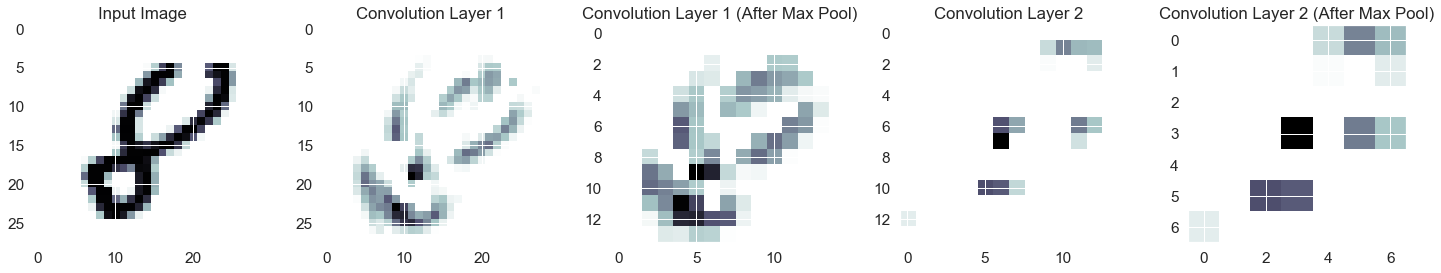

In [146]:
# choose a random test input image from test data set
image_number = np.random.randint(0, x_test.shape[0])

# a random output channel for each convolutional layer based on number of filters for that layer
filter_1 = np.random.randint(0,32)
filter_2 = np.random.randint(0,64)

fig, ax = plt.subplots(1,5,figsize=(25,4))

image1 = ax[0].imshow(x_test[image_number][:,:,0], cmap='bone_r')
ax[0].set_title('Input Image')

image2 = ax[1].imshow(layer_outs[0][0][image_number][:,:,filter_1], cmap='bone_r')
ax[1].set_title('Convolution Layer 1')

image3 = ax[2].imshow(layer_outs[1][0][image_number][:,:,filter_1], cmap='bone_r')
ax[2].set_title('Convolution Layer 1 (After Max Pool)')

image4 = ax[3].imshow(layer_outs[2][0][image_number][:,:,filter_2], cmap='bone_r')
ax[3].set_title('Convolution Layer 2')

image5 = ax[4].imshow(layer_outs[3][0][image_number][:,:,filter_2], cmap='bone_r')
ax[4].set_title('Convolution Layer 2 (After Max Pool)')
